<a href="https://colab.research.google.com/github/Batman511/Object_detection/blob/main/%D0%94%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D1%84%D0%BE%D1%82%D0%BE_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BF%D1%8B%D0%BB%D0%B8_%D0%B2_%D1%80%D0%B5%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import matplotlib.image as img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Модель DETR

DETR = сверточная нейросеть ResNet50 + трансформер с 6 слоями енкодеров и декодеров. Не требует использования нмс (алгоритм выбора рамки для одного объекта), каждому объекту соответствует одна рамка. Не требует большой выборки для обучения (была дообучена на 3х картинках и показала хороший результат распознавания). Хорошо справляется с наложенными друг на друга объектами, но имеет ограничение в 100 объектов.



## Для получения текста с картинки можно использовать pytesseract

In [ ]:
pip install pytesseract

In [ ]:
pip install tesseract-ocr

Вырезаем информационную таблицу под картинкой и получаем информацию в виде текста

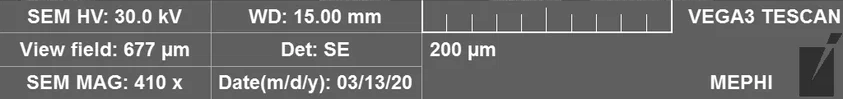

In [47]:
import pytesseract

base = '/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/'
name = '56-100.png'
data_1 = base + name
im = Image.open(data_1)

text_img = im.crop((0, im.size[1] - im.size[1] / 9.5, im.size[0], im.size[1]))
text_img

In [ ]:
# если использовать код локально, то прописать pytesseract.pytesseract.tesseract_cmd = r'C:\Users\USER\AppData\Local\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
text = pytesseract.image_to_string(text_img)

izmer = text.split("field: ")[1].split()[1].replace("u", "μ")
all_len = float(text.split("field: ")[1].split()[0]) * 1000 if izmer == "mm" else float(text.split("field: ")[1].split()[0]) 

## Threshold для бинаризации и лучшего выделения объектов

Количество объектов на изображении: 201
Число пылинок с размером > 100:  44


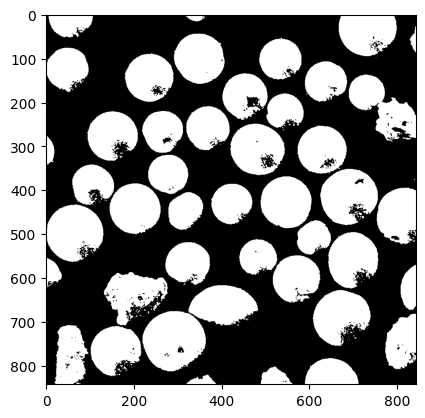

In [34]:
import cv2

# Загружаем изображение
base = '/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/'
name = '56-100.png'
data_1 = base + name
img = Image.open(data_1)


# обрезаем фото, переводим в оттенки серого, добавляем размытие и сохраняем под новым названием
img = img.crop((0, 0, img.size[0], img.size[1] - img.size[1]/9.5))
img.save(base + 'crop_' + name)
img = cv2.imread(base + 'crop_' + name, cv2.IMREAD_GRAYSCALE)
img = cv2.GaussianBlur(img, (3, 3), 0)



clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
img = clahe.apply(img)
# Применяем бинаризацию изображения
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Находим контуры объектов на изображении
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))



# Создаем список для хранения размеров объектов
object_sizes = []

# Обходим найденные контуры и определяем размеры каждого объекта
for contour in contours:
    # Вычисляем площадь контура
    contour_area = cv2.contourArea(contour)
    area_px = 100
    if  contour_area > area_px:
        object_sizes.append(contour)  


print('Количество объектов на изображении:', len(contours))
print('Число пылинок с размером > {}: '.format(area_px), len(object_sizes))

Визуализируем обведенные границы

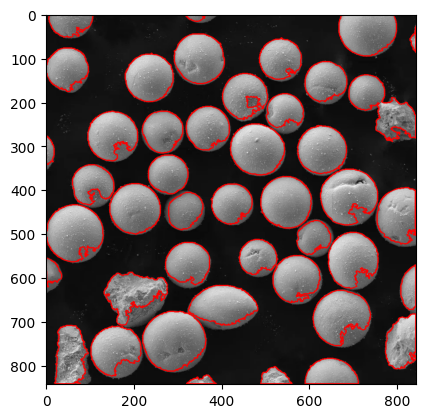

In [33]:
res = cv2.imread(base + 'crop_' + name)
cv2.drawContours(res, object_sizes, -1, (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## Canny для выделения границ

Canny требует верхнюю и нижнюю границу для определения размеров объектов, можно использовать алгоритма OTSU для их подсчета, но проще пользоваться Threshold


Количество объектов на изображении: 84
Число пылинок с размером > 100:  16


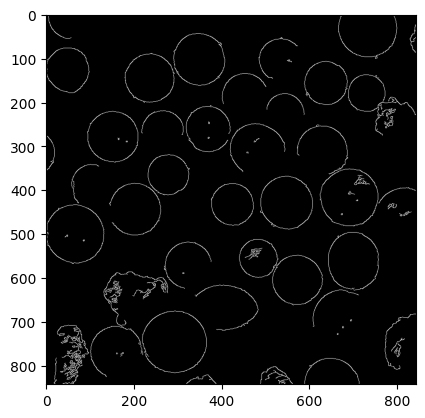

In [36]:
edges = cv2.Canny(img, 100, 400, apertureSize=3)

dilated = cv2.dilate(edges, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')
contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
object_sizes = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100:
        object_sizes.append('Large')   

print('Количество объектов на изображении:', len(contours))
print('Число пылинок с размером > {}: '.format(area_px), len(object_sizes))

Работает хуже Threshold

## DETR

https://colab.research.google.com/drive/1JXmtDlhF6q8FrW5AeavwOQjkGvBoVeM1

Для скачивания исходной модели и работы с ней

### Модель

In [ ]:
pip install timm

In [ ]:
%pip install torch torchvision transformers scipy pycocotools coco-eval matplotlib

In [40]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import timm

# загрузка модели
model = DetrForObjectDetection.from_pretrained(
    'facebook/detr-resnet-50',
    num_labels=1,
    ignore_mismatched_sizes=True
)
# model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/model_detr.pth'))  # загрузка коэффициентов модели, предобученной только на шариках
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/model_detr_dust (1).pth'))  # загрузка коэффициентов модели, дообученной на трех размеченных картинках

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

Используем видеопамять

In [50]:
DEVICE = 'cuda'
model = model.to(DEVICE)

In [41]:
def convert_to_xywh(_boxes):
    x_min, y_min, x_max, y_max = _boxes.unbind(1)
    return torch.stack((x_min, y_min, x_max - x_min, y_max - y_min), dim=1)

def prepare_for_coco_detection(_predictions):
    coco_results = []
    for original_id, prediction in _predictions.items():
        if len(prediction) == 0:
            continue

        _boxes = prediction["boxes"]
        _boxes = convert_to_xywh(_boxes).tolist()
        _scores = prediction["scores"].tolist()
        _labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": _labels[k],
                    "bbox": _box,
                    "score": _scores[k],
                }
                for k, _box in enumerate(_boxes)
            ]
        )
    return coco_results

### Загрузка картинки

1 вариант загрузки - проще использовать его!

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys(): 
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn,length=len(uploaded[fn])))

In [ ]:
data_1 = 'general view 1-5.jpg'
im = Image.open(data_1)

2 вариант загрузки

In [ ]:
data_1='/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/56-100.png'
im = Image.open(data_1)
im

3 вариант загрузки

In [ ]:
data_1='/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/IT.Mephi.Hackathon.Data/2 (2).png'
png = Image.open(data_1)
png.load()

background = Image.new("RGB", png.size, (255, 255, 255))
background.paste(png, mask=png.split()[3])

background.save('/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/2 (2).jpg', 'JPEG', quality=95)
im = background

### Работа с целой картинкой

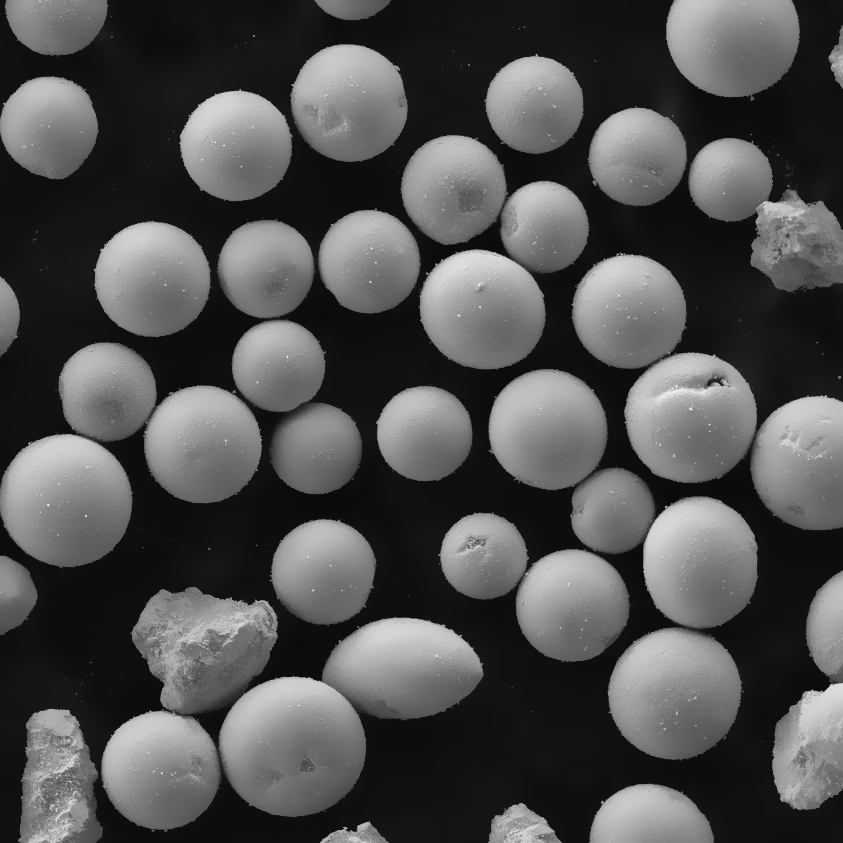

In [78]:
img_width, img_height = im.size
im_crop = im.crop((0, 0, img_width, img_width))
im_crop


# Заблюрим
image = img_to_array(im_crop, dtype = "uint8") 
blur = cv2.bilateralFilter(image, 21, 55, 55)
im_crop = Image.fromarray(blur)
im_crop

In [53]:
# препроцесор нужен для формирования входа в трансформер
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [79]:
#прогонка на одном фото
encoding = processor(images=im_crop, return_tensors="pt")
pixel_values = encoding['pixel_values'].squeeze()
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [80]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (x_min, y_min, x_max, y_max),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        text = f'{score:0.2f}'
        ax.text(x_min, y_min, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

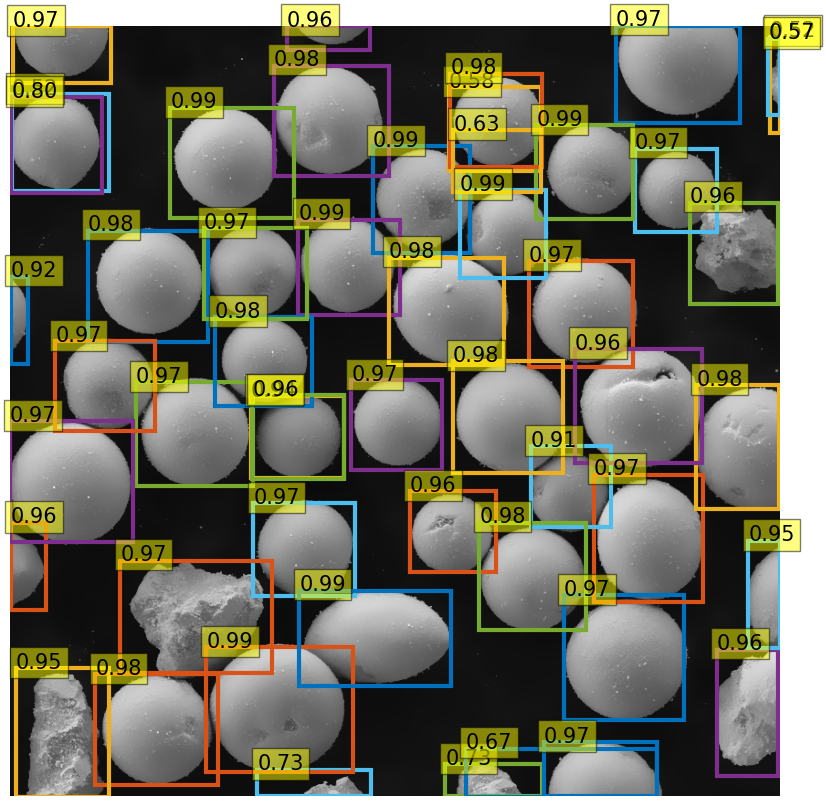

Число пылинок на картинке:  51


In [81]:
width, height = im_crop.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.5
)

results = postprocessed_outputs[0]
plot_results(im_crop, results['scores'], results['labels'], results['boxes'])
print("Число пылинок на картинке: ", len(results['labels']))

### Делим картинку на 4 части в случае большого числа частиц

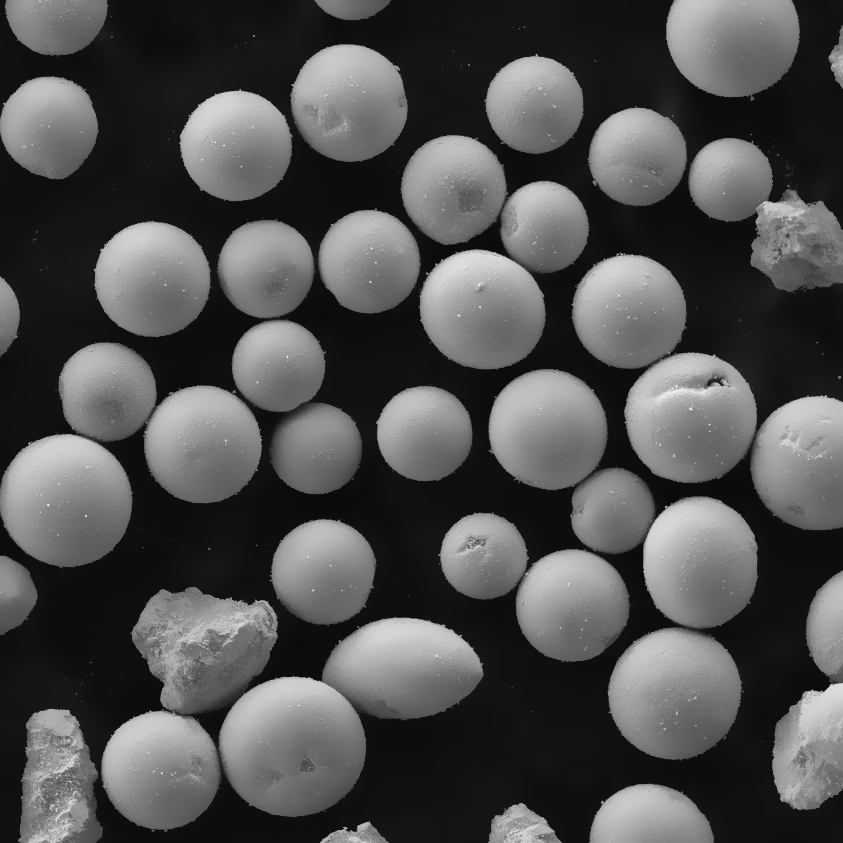

In [57]:
img_width, img_height = im.size
im_crop = im.crop((0, 0, img_width, img_width))
im_crop


# Заблюрим
image = img_to_array(im_crop, dtype = "uint8") 
blur = cv2.bilateralFilter(image, 21, 55, 55)
im_crop = Image.fromarray(blur)
im_crop

In [58]:
img_width, img_height = im_crop.size
im_crop_1 = im_crop.crop((0,0, img_width/2, img_width/2))
im_crop_2 = im_crop.crop((img_width/2 ,0, img_width, img_width/2))
im_crop_3 = im_crop.crop((0, img_width/2, img_width/2, img_width))
im_crop_4 = im_crop.crop((img_width/2,img_width/2, img_width, img_width))

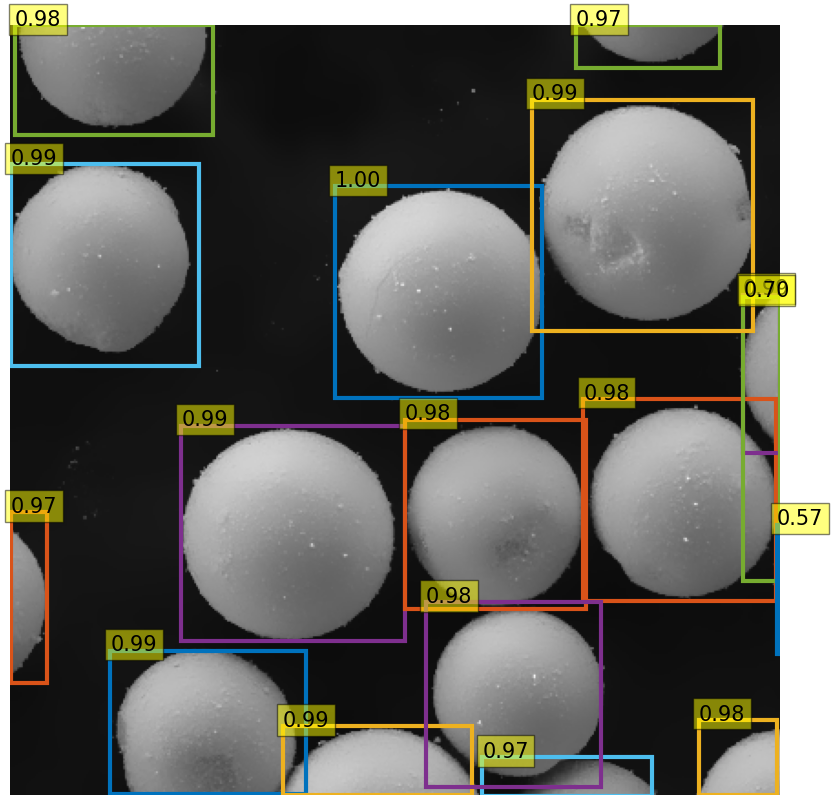

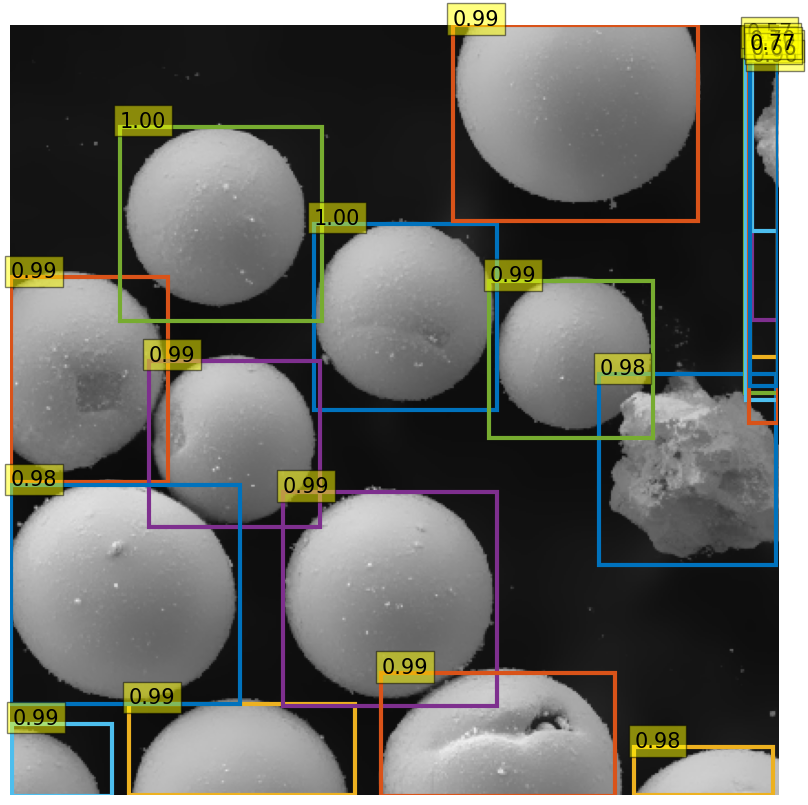

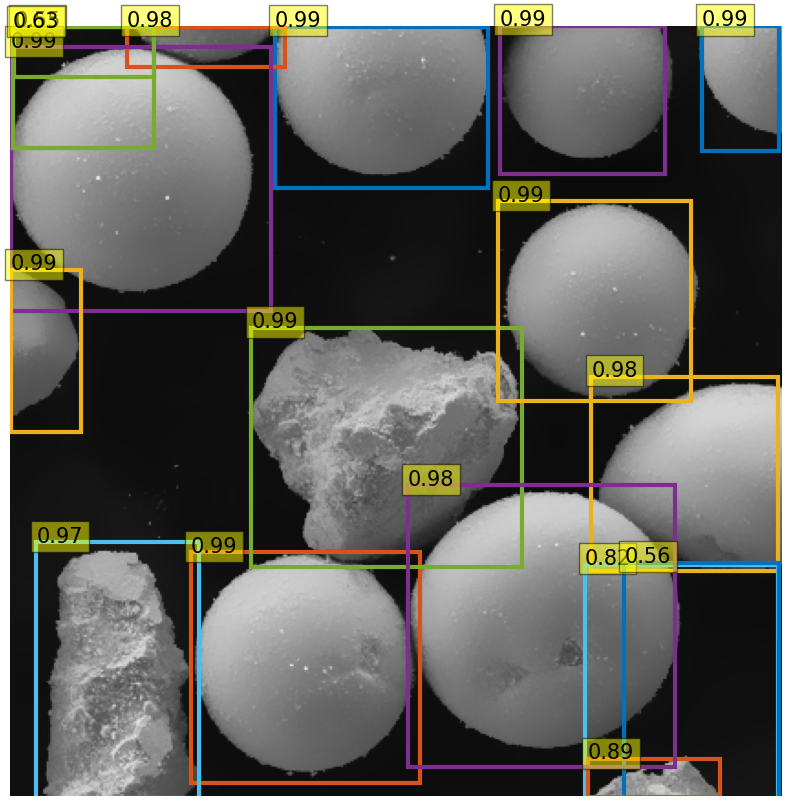

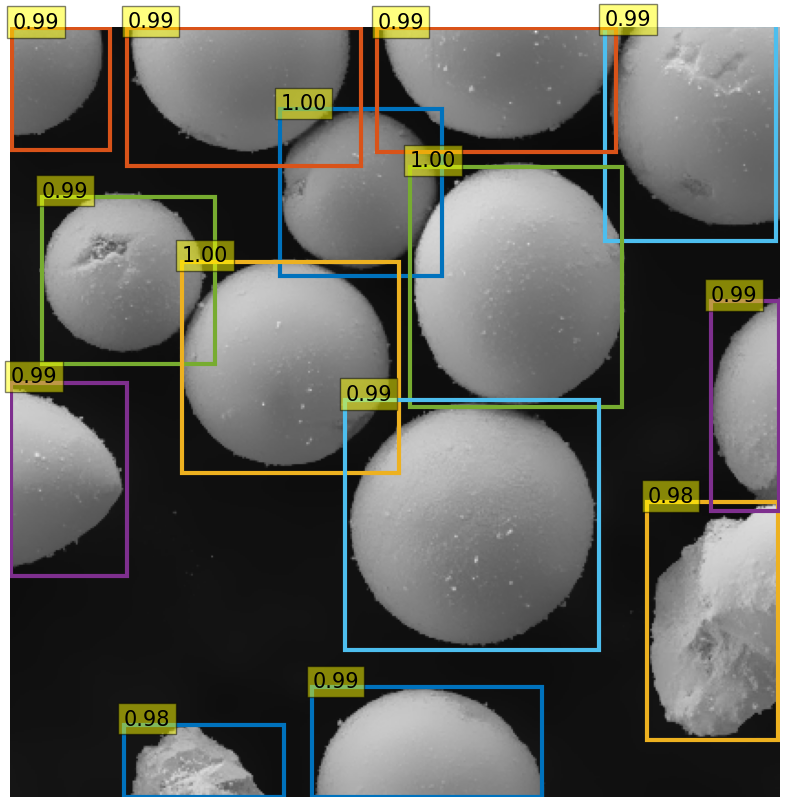

In [59]:
encoding = processor(images=im_crop_1, return_tensors="pt")
pixel_values = encoding['pixel_values'].squeeze()
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

width, height = im_crop_1.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.5
)

results_1 = postprocessed_outputs[0]
plot_results(im_crop_1, results_1['scores'], results_1['labels'], results_1['boxes'])






encoding = processor(images=im_crop_2, return_tensors="pt")
pixel_values = encoding['pixel_values'].squeeze()
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

width, height = im_crop_2.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.5
)

results_2 = postprocessed_outputs[0]
plot_results(im_crop_2, results_2['scores'], results_2['labels'], results_2['boxes'])






encoding = processor(images=im_crop_3, return_tensors="pt")
pixel_values = encoding['pixel_values'].squeeze()
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

width, height = im_crop_3.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.5
)

results_3 = postprocessed_outputs[0]
plot_results(im_crop_3, results_3['scores'], results_3['labels'], results_3['boxes'])







encoding = processor(images=im_crop_4, return_tensors="pt")
pixel_values = encoding['pixel_values'].squeeze()
pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

width, height = im_crop_4.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.5
)

results_4 = postprocessed_outputs[0]
plot_results(im_crop_4, results_4['scores'], results_4['labels'], results_4['boxes'])

In [95]:
print("Общее число пылинок на картинке: ", len(results_1['labels'])+len(results_2['labels'])+len(results_3['labels'])+len(results_4['labels']))

Общее число пылинок на картинке:  68


### Распределение размеров частиц (в пикселях)

распределение по длинам вдоль оси х

(array([ 3.,  2.,  1.,  1., 21., 12.,  7.,  3.,  0.,  1.]),
 array([ 10.93164062,  30.77132034,  50.61100006,  70.45067596,
         90.2903595 , 110.1300354 , 129.9697113 , 149.80938721,
        169.64907837, 189.48875427, 209.32843018]),
 <BarContainer object of 10 artists>)

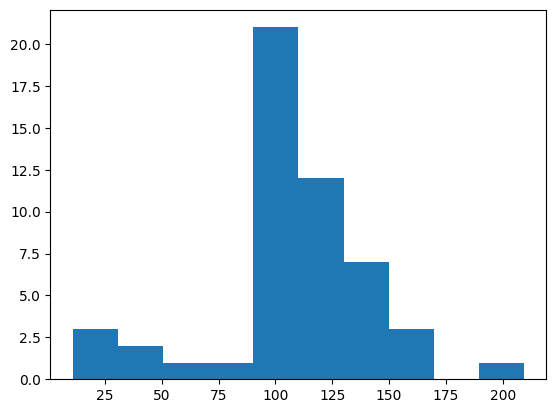

In [63]:
plt.hist(torch.abs(results['boxes'][:,0]-results['boxes'][:,2]).detach().cpu())

распределение по длинам вдоль оси y

(array([ 3.,  0.,  2.,  2.,  1.,  6., 15.,  8.,  7.,  7.]),
 array([ 26.05436707,  37.53919601,  49.02402496,  60.5088501 ,
         71.99368286,  83.478508  ,  94.96333313, 106.44816589,
        117.93299103, 129.41781616, 140.90264893]),
 <BarContainer object of 10 artists>)

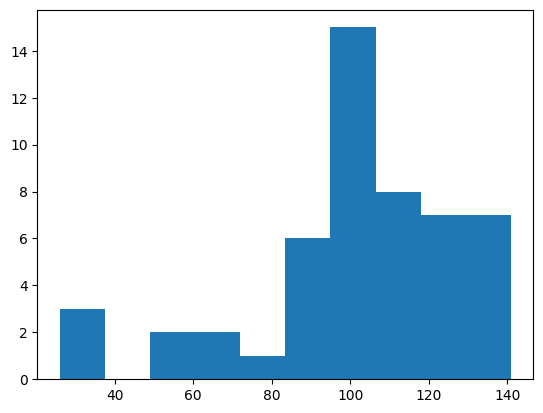

In [64]:
plt.hist(torch.abs(results['boxes'][:,1]-results['boxes'][:,3]).detach().cpu())

Для картинок, разделенных на 4 части

In [ ]:
tens12 = torch.cat((torch.abs(results_1['boxes'][:,1]-results_1['boxes'][:,3]).detach().cpu(), torch.abs(results_2['boxes'][:,1]-results_2['boxes'][:,3]).detach().cpu()), -1)
tens34 = torch.cat((torch.abs(results_3['boxes'][:,1]-results_3['boxes'][:,3]).detach().cpu(), torch.abs(results_4['boxes'][:,1]-results_4['boxes'][:,3]).detach().cpu()), -1)
tens = torch.cat(( tens12,tens34  ), -1)
a = int(np.sum(plt.hist(tens)[0]))

### Таблица в нм

In [ ]:
def write_table(results):
    X = plt.hist(torch.abs(results['boxes'][:,0]-results['boxes'][:,2]).detach().cpu() * nm_per_pixel)
    Y = plt.hist(torch.abs(results['boxes'][:,1]-results['boxes'][:,3]).detach().cpu() * nm_per_pixel)
    count_delta_x = X[0]
    delta_x = X[1]
    count_delta_y = Y[0]
    delta_y = Y[1]
    delta_x_1 = np.zeros(len(count_delta_x))
    delta_y_1 = np.zeros(len(count_delta_y))
    for i in range(len(delta_x_1)):
        delta_x_1[i] = (delta_x[i+1] + delta_x[i])/2
        delta_y_1[i] = (delta_y[i+1] + delta_y[i])/2
    X = pd.DataFrame([count_delta_x.astype(int), delta_x_1], ['counts', 'size_x'])
    Y = pd.DataFrame([count_delta_y.astype(int), delta_y_1], ['counts', 'size_y'])
    return X, Y

In [ ]:
name = '/content/56-100.jpg'
name1 = name.split('/')[2]
name1 = name1[:-3] + 'png'
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Хакатон/Анализ пыли/IT.Mephi.Hackathon.ImageInfo - Лист1.csv', header=None, names = ['name', 'size', '!!!'])   # таблица с именами файлов и шириной картинок в нм
df = df.drop('!!!', axis=1)
size = df[df['name']==name1]['size']

nm_per_pixel = int(size) / width
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
count_delta_x

,0,1,2,3,4,5,6,7,8,9
counts,2.000000,0.000000,1.000000,3.000000,1.000000,2.00000,1.000000,1.000000,2.000000,2.000000
size_x,87.072735,91.908806,96.744881,101.580952,106.417019,111.25309,116.089165,120.925236,125.761303,130.597374


In [ ]:
count_delta_y

,0,1,2,3,4,5,6,7,8,9
counts,1.0000,0.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,3.000000,3.000000
size_y,50.8766,59.026728,67.176857,75.326984,83.477108,91.627235,99.777367,107.927494,116.077618,124.227745
